In [107]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn

In [108]:
df = pd.read_csv('airline-passengers.csv')
timeseries = df[["Passengers"]].values.astype('float32')
timeseries

array([[112.],
       [118.],
       [132.],
       [129.],
       [121.],
       [135.],
       [148.],
       [148.],
       [136.],
       [119.],
       [104.],
       [118.],
       [115.],
       [126.],
       [141.],
       [135.],
       [125.],
       [149.],
       [170.],
       [170.],
       [158.],
       [133.],
       [114.],
       [140.],
       [145.],
       [150.],
       [178.],
       [163.],
       [172.],
       [178.],
       [199.],
       [199.],
       [184.],
       [162.],
       [146.],
       [166.],
       [171.],
       [180.],
       [193.],
       [181.],
       [183.],
       [218.],
       [230.],
       [242.],
       [209.],
       [191.],
       [172.],
       [194.],
       [196.],
       [196.],
       [236.],
       [235.],
       [229.],
       [243.],
       [264.],
       [272.],
       [237.],
       [211.],
       [180.],
       [201.],
       [204.],
       [188.],
       [235.],
       [227.],
       [234.],
       [264.],
       [30

In [109]:
# d1 = pd.read_csv('abc_sales.csv')
# d1['sales'] = d1[['sales']].values.astype('float32')

# d2 = pd.read_csv('abc_calendar.csv')

# def quarter_date(date):
#     for _, row in d2.iterrows():
#         if date <= row['end_date']:
#             return row['end_date']
        
# d1['quarter_Date'] = d1['date'].apply(quarter_date)
# df_quarterly = d1.groupby('quarter_Date').sum()
# # timeseries = df_quarterly[['sales']].reset_index(drop=True)
# timeseries = df_quarterly[["sales"]].values.astype('float32')
# timeseries

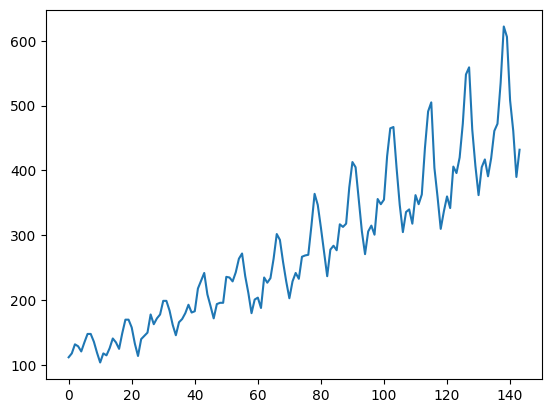

In [110]:
plt.plot(timeseries)
plt.show()

In [111]:
# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [112]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [113]:
lookback = 5  # If there is strong temporal dependency, meaning that past values have a significant influence on future values, a larger lookback may be beneficial. 
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([91, 5, 1]) torch.Size([91, 5, 1])
torch.Size([43, 5, 1]) torch.Size([43, 5, 1])


In [114]:
X_train

tensor([[[112.],
         [118.],
         [132.],
         [129.],
         [121.]],

        [[118.],
         [132.],
         [129.],
         [121.],
         [135.]],

        [[132.],
         [129.],
         [121.],
         [135.],
         [148.]],

        [[129.],
         [121.],
         [135.],
         [148.],
         [148.]],

        [[121.],
         [135.],
         [148.],
         [148.],
         [136.]],

        [[135.],
         [148.],
         [148.],
         [136.],
         [119.]],

        [[148.],
         [148.],
         [136.],
         [119.],
         [104.]],

        [[148.],
         [136.],
         [119.],
         [104.],
         [118.]],

        [[136.],
         [119.],
         [104.],
         [118.],
         [115.]],

        [[119.],
         [104.],
         [118.],
         [115.],
         [126.]],

        [[104.],
         [118.],
         [115.],
         [126.],
         [141.]],

        [[118.],
         [115.],
         

In [115]:
y_train

tensor([[[118.],
         [132.],
         [129.],
         [121.],
         [135.]],

        [[132.],
         [129.],
         [121.],
         [135.],
         [148.]],

        [[129.],
         [121.],
         [135.],
         [148.],
         [148.]],

        [[121.],
         [135.],
         [148.],
         [148.],
         [136.]],

        [[135.],
         [148.],
         [148.],
         [136.],
         [119.]],

        [[148.],
         [148.],
         [136.],
         [119.],
         [104.]],

        [[148.],
         [136.],
         [119.],
         [104.],
         [118.]],

        [[136.],
         [119.],
         [104.],
         [118.],
         [115.]],

        [[119.],
         [104.],
         [118.],
         [115.],
         [126.]],

        [[104.],
         [118.],
         [115.],
         [126.],
         [141.]],

        [[118.],
         [115.],
         [126.],
         [141.],
         [135.]],

        [[115.],
         [126.],
         

In [116]:
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [117]:
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 225.6607, test RMSE 425.4337
Epoch 100: train RMSE 179.0620, test RMSE 376.6174
Epoch 200: train RMSE 143.0885, test RMSE 337.4468
Epoch 300: train RMSE 113.4113, test RMSE 302.6367
Epoch 400: train RMSE 91.1194, test RMSE 272.2179
Epoch 500: train RMSE 68.9207, test RMSE 239.3468
Epoch 600: train RMSE 53.5810, test RMSE 210.4080
Epoch 700: train RMSE 42.8391, test RMSE 185.9870
Epoch 800: train RMSE 35.6223, test RMSE 164.8384
Epoch 900: train RMSE 30.3403, test RMSE 146.5335
Epoch 1000: train RMSE 26.9264, test RMSE 131.2092
Epoch 1100: train RMSE 24.5511, test RMSE 118.7787
Epoch 1200: train RMSE 22.8803, test RMSE 107.5635
Epoch 1300: train RMSE 21.5172, test RMSE 99.9367
Epoch 1400: train RMSE 21.4207, test RMSE 93.9172
Epoch 1500: train RMSE 20.1806, test RMSE 89.2795
Epoch 1600: train RMSE 19.6866, test RMSE 85.3237
Epoch 1700: train RMSE 19.4256, test RMSE 81.7406
Epoch 1800: train RMSE 18.9058, test RMSE 80.0747
Epoch 1900: train RMSE 18.4758, test RMSE 77.

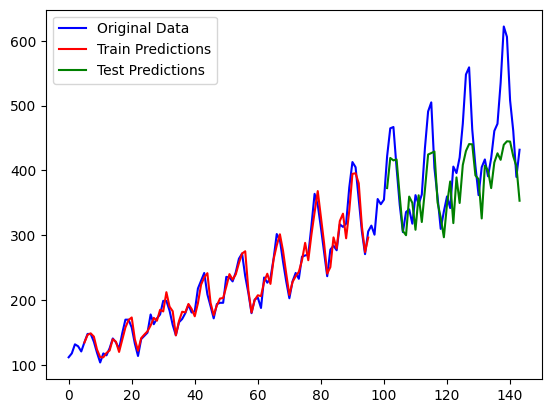

In [118]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]

plt.plot(timeseries, c='b', label='Original Data')
plt.plot(train_plot, c='r', label='Train Predictions')
plt.plot(test_plot, c='g', label='Test Predictions')
plt.legend()
plt.show()